###Step 2

In [ ]:
import numpy as np

def sequential_portfolio_selection(historical_returns, K, N, delta):
    # Filter to select a basket of K assets
    selected_assets = select_assets(historical_returns, K)

    # Initialize regret
    regret = 0

    for t in range(N):
        # Choose portfolio weights ωt = ω1,t, ... , ωK,t
        portfolio_weights = compute_portfolio_weights(historical_returns, selected_assets, t, delta)

        # Observe returns Rt = R1,t, ... ,RK,t
        observed_returns = get_returns(selected_assets, t)

        # Compute portfolio reward ωt Rt
        portfolio_reward = np.dot(portfolio_weights, observed_returns)

        # Update regret
        regret += np.max(np.mean(historical_returns, axis=1)) - portfolio_reward

    return regret

def select_assets(historical_returns, K):
    # Implement asset selection logic
    pass

def compute_portfolio_weights(historical_returns, selected_assets, t, delta):
    # Implement portfolio weight computation logic
    pass

def get_returns(selected_assets, t):
    # Retrieve observed returns for selected assets at time t
    pass


##Step 3

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.random import rand, seed
import matplotlib.pyplot as plt
import statistics
try:
  from tabulate import tabulate
except ImportError:
  !pip install tabulate

pd.set_option('display.max_columns', None)

In [ ]:
fin_tickers = ['JPM','WFC', 'BAC', 'C', "GS",
'USB', 'MS', 'KEY', 'PNC', 'COF', 'AXP', 'PRU', 'SCHW', 'BCS', 'HSBC' #'BBT', 'STI'
]
non_fin_tickers=['KR', 'PFE', 'XOM', 'WMT',
'DAL', 'CSCO', 'EQIX', 'DUK', 'NFLX', 'GE', 'APA', 'F', 'REGN', 'CMS', 'AMZN' #'HCP'
]

all_tickers = fin_tickers + non_fin_tickers
all_data = yf.download(all_tickers, '2008-09-01', '2008-10-31')

[*********************100%%**********************]  30 of 30 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

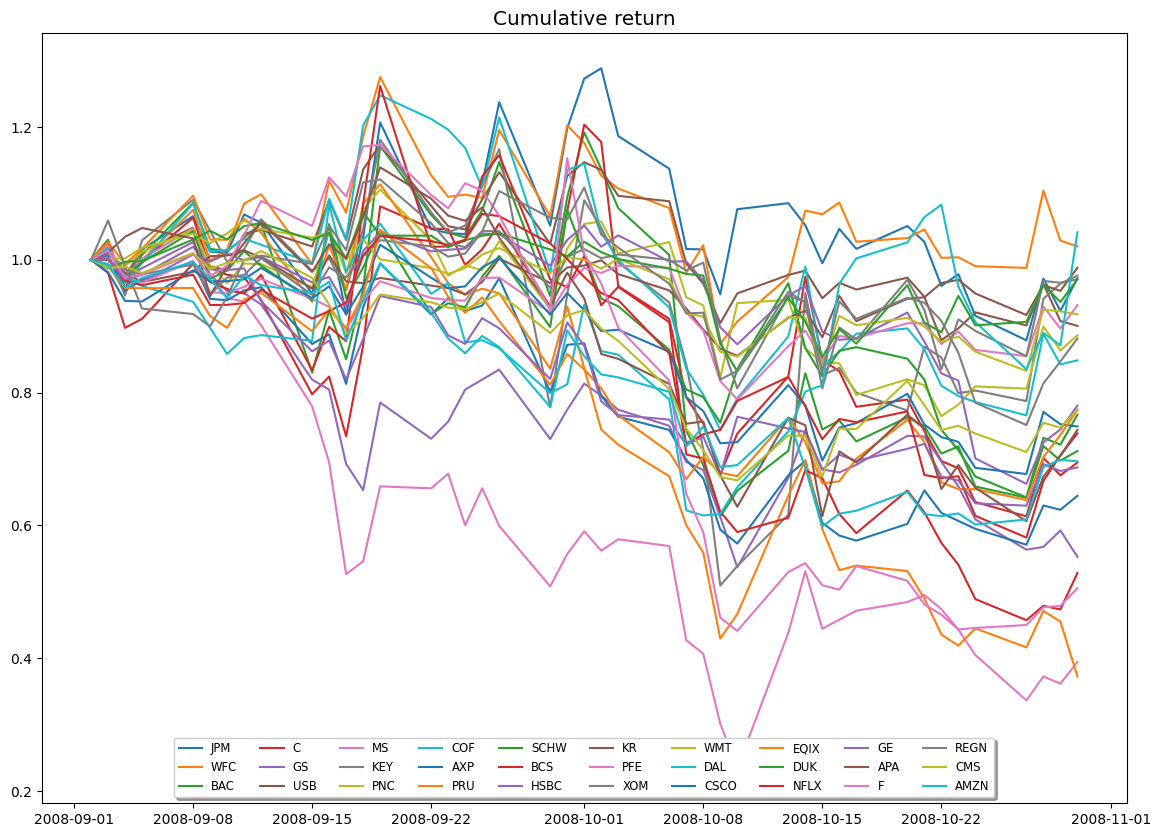

In [ ]:
stock_returns = all_data['Adj Close'].pct_change()

df=pd.DataFrame()
df_ret=pd.DataFrame()
for tick in all_tickers:
  price=yf.download(tick, start='2008-09-01',end='2008-10-31')
  plt.plot(price['Adj Close']/price['Adj Close'][0], label = tick)
  price=price.rename(columns={'Adj Close':tick})
  price[tick+'ret']=price[tick].pct_change()
  df=pd.concat([df, price[[tick]]],axis=1)
  df_ret=pd.concat([df,price[[tick+'ret']]], axis =1)
pdata=df.to_numpy()
pdata_dates=pd.to_datetime(price.index, format='%Y-%m-%d')
legend=plt.legend(loc='lower center', ncols=10,shadow=True, fontsize='small')
title='Cumulative return'
plt.title(title, fontsize='x-large')
fig=plt.gcf()
fig.set_size_inches(14,10)
plt.show()

## STEP 4

In [ ]:
corr_matrix = stock_returns.corr()
# sort and create a unique list of stocks
dd = {i[0]: 1 for i in corr_matrix.unstack().sort_values().index}
sorted_cols = list(dd.keys())
sorted_corr_mat = stock_returns[sorted_cols].corr().round(2)


In [ ]:
#sns.heatmap(corr_matrix, cmap='coolwarm')
#ns.heatmap(sorted_corr_mat, cmap='coolwarm')

sorted_corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)


<ipython-input-7-424603e35961>:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  sorted_corr_mat.style.background_gradient(cmap='coolwarm').set_precision(2)


,KEY,NFLX,MS,PNC,GS,DUK,GE,DAL,PRU,XOM,JPM,USB,BAC,C,AMZN,BCS,WMT,EQIX,SCHW,HSBC,WFC,AXP,F,REGN,APA,KR,COF,CMS,CSCO,PFE
KEY,1.00,0.17,0.53,0.42,0.60,0.22,0.49,0.41,0.59,0.41,0.52,0.59,0.75,0.74,0.37,0.57,0.46,0.37,0.38,0.48,0.70,0.70,0.56,0.41,0.41,0.48,0.73,0.46,0.46,0.65
NFLX,0.17,1.00,0.30,0.44,0.23,0.44,0.50,0.45,0.37,0.49,0.53,0.46,0.54,0.47,0.60,0.53,0.63,0.64,0.56,0.60,0.38,0.39,0.42,0.59,0.57,0.45,0.50,0.62,0.72,0.52
MS,0.53,0.30,1.00,0.17,0.81,0.57,0.25,0.43,0.68,0.64,0.31,0.36,0.54,0.55,0.51,0.44,0.56,0.58,0.46,0.59,0.43,0.71,0.59,0.53,0.67,0.57,0.49,0.64,0.62,0.77
PNC,0.42,0.44,0.17,1.00,0.19,0.40,0.74,0.39,0.54,0.44,0.83,0.86,0.65,0.62,0.68,0.49,0.51,0.54,0.72,0.40,0.75,0.59,0.51,0.47,0.41,0.44,0.67,0.44,0.58,0.55
GS,0.60,0.23,0.81,0.19,1.00,0.40,0.31,0.32,0.60,0.59,0.46,0.40,0.66,0.62,0.48,0.53,0.44,0.59,0.45,0.58,0.51,0.70,0.50,0.45,0.60,0.53,0.49,0.59,0.60,0.66
DUK,0.22,0.44,0.57,0.40,0.40,1.00,0.30,0.27,0.50,0.81,0.34,0.42,0.37,0.37,0.58,0.39,0.70,0.54,0.40,0.67,0.39,0.56,0.44,0.64,0.72,0.63,0.44,0.72,0.70,0.71
GE,0.49,0.50,0.25,0.74,0.31,0.30,1.00,0.35,0.52,0.45,0.78,0.72,0.70,0.70,0.70,0.51,0.56,0.61,0.73,0.55,0.69,0.63,0.46,0.50,0.53,0.42,0.70,0.52,0.66,0.56
DAL,0.41,0.45,0.43,0.39,0.32,0.27,0.35,1.00,0.27,0.30,0.53,0.48,0.56,0.46,0.37,0.52,0.45,0.45,0.54,0.38,0.47,0.45,0.40,0.60,0.45,0.60,0.51,0.48,0.46,0.49
PRU,0.59,0.37,0.68,0.54,0.60,0.50,0.52,0.27,1.00,0.61,0.48,0.67,0.62,0.62,0.63,0.46,0.60,0.62,0.66,0.54,0.70,0.75,0.73,0.54,0.60,0.44,0.75,0.53,0.68,0.65
XOM,0.41,0.49,0.64,0.44,0.59,0.81,0.45,0.30,0.61,1.00,0.46,0.56,0.54,0.49,0.68,0.41,0.82,0.71,0.55,0.68,0.53,0.68,0.53,0.69,0.92,0.68,0.59,0.80,0.81,0.82


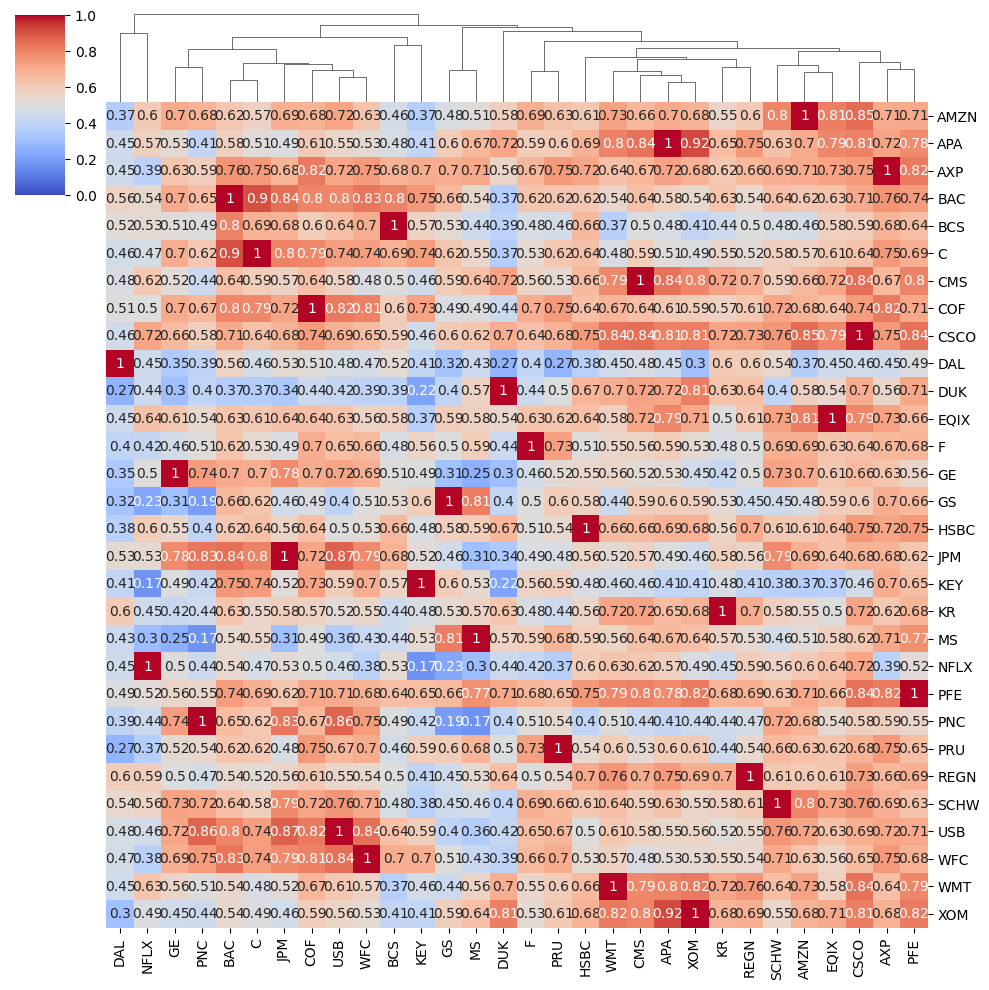

In [ ]:
heatmap = sns.clustermap (corr_matrix, row_cluster= False, vmin = 0, vmax =1, dendrogram_ratio = 0.1, cmap='coolwarm', annot=True)

## Strong Positive Correlations:

- AMZN, APA, and AXP

- CMS, COF, and CSCO

- GE and PNC

- SCHW and the other clusters, except for WFC

## Strong Negative Correlations:

- BAC and JPM

- DAL and NFLX

These strong correlations suggest that the clusters within each group are closely related to each other. For example, AMZN, APA, and AXP may be related to the technology sector, while CMS, COF, and CSCO may be related to the healthcare sector. The strong negative correlations between BAC and JPM, and DAL and NFLX, suggest that these clusters may be inversely related to each other. For example, BAC and JPM may be related to the banking sector, while DAL and NFLX may be related to the entertainment sector.

## **STEP 6**

## MAB Common Functions

In [ ]:
# Common functions for MAB problems
def optimal_action(qvalue, eps):  # noQA E203
    """
    Determines what is the action to take given a measure of past
    expected rewards across actions. With probability eps the action
    is not the greedy one
    """
    nactions = qvalue.shape[0]
    action_hat = np.where(qvalue == np.max(qvalue))

    if rand() <= eps:
        randnum = rand()
        for aa in range(nactions):
            if randnum < (aa + 1) / nactions:  # noQA E203
                break
    elif action_hat[0].shape[0] > 1:  # noQA E203
        # Randomize action when ties
        randnum = rand()
        for aa in range(action_hat[0].shape[0]):  # noQA E203
            if randnum < (aa + 1) / action_hat[0].shape[0]:  # noQA E203
                break
        aa = action_hat[0][aa]
    else:
        aa = np.argmax(qvalue)

    return aa

def reward_update(action, reward, qvalue_old, alpha):  # noQA E203
    qvalue_new = qvalue_old.copy()

    qvalue_new[action] = qvalue_old[action] + alpha * (reward - qvalue_old[action])

    return qvalue_new

**Algo for UCB**



In [ ]:
all_prices = all_data['Adj Close']
YData_dates = pd.to_datetime(all_prices.reset_index()['Date'], format="%Y-%m-%d")

In [ ]:
NEPISODES = 1000
HOLD = 1

def UCBMultiBandit (all_prices, eps, N, h, a = None):

  YData = all_prices.to_numpy()
  NK = all_prices.shape[1] # number of stocks
  TMAX = all_prices.shape[0] - HOLD

  seed(1234)

  reward_avg_ucb = np.zeros((TMAX))
  optimal_avg_ucb = np.zeros((TMAX))
  reward_queue_ucb = np.zeros((HOLD, 2))

  for run in range(NEPISODES):  # noQA E203
    # Initialize q function and actions record
    qvalue = np.zeros((NK))
    qvalue_up = np.zeros((NK))
    nactions = np.zeros((NK))

    for tt in range(TMAX):  # noQA E203
        aa_opt = optimal_action(qvalue_up, eps)
        nactions[aa_opt] += 1

        # Compute reward as return over holding period
        reward_queue_ucb[HOLD - 1, 0] = (
            YData[tt + HOLD, aa_opt] - YData[tt, aa_opt]
        ) / YData[tt, aa_opt]

        reward_queue_ucb[HOLD - 1, 1] = aa_opt

        # Update Q function using action chosen HOLD days before
        if (a == None):
          alpha = 1 / nactions[aa_opt]
        else:
          alpha = a
        qvalue = reward_update(
            int(reward_queue_ucb[0, 1]), reward_queue_ucb[0, 0], qvalue, alpha
        )

        # Upper-confidence adjustment
        qvalue_up = np.zeros((NK))
        for aa in range(NK): #for all 30 stocks
            if nactions[aa] == 0:  # noQA E203
                qvalue_up[aa] = np.max(qvalue) + 1.0
            else:
                qvalue_up[aa] = qvalue[aa] + UCB_EXPORATION_PARAM * np.sqrt(np.log(tt + 1) / nactions[aa])
        reward_queue_ucb[0 : HOLD - 1, :] = reward_queue_ucb[1:HOLD, :]  # noQA E203
        reward_avg_ucb[tt] += reward_queue_ucb[HOLD - 1, 0] / NEPISODES
        optimal_avg_ucb[tt] += (
            aa_opt == np.argmax((YData[tt + HOLD, :] - YData[tt, :]) / YData[tt, :])
        ) / NEPISODES  # noQA E203
  return optimal_avg_ucb, reward_avg_ucb

**Here we plot four charts for UCB Algo**

1/ Frequency of optimal action

2/ Max Return vs. UCB Average Reward

3/ Average Reward (Equally Weighted) vs. UCB

4/ Cumulative Return

In [ ]:
EPSILON = 0 # epsilon = 0 for UCB
# ALPHA = 0.975 # We set alpha as simply 1 / number of time action has chosen

TMAX = all_prices.shape[0] - HOLD
UCB_EXPORATION_PARAM = 2

optimal_avg_ucb, reward_avg_ucb  = UCBMultiBandit (all_prices, EPSILON, NEPISODES, HOLD)



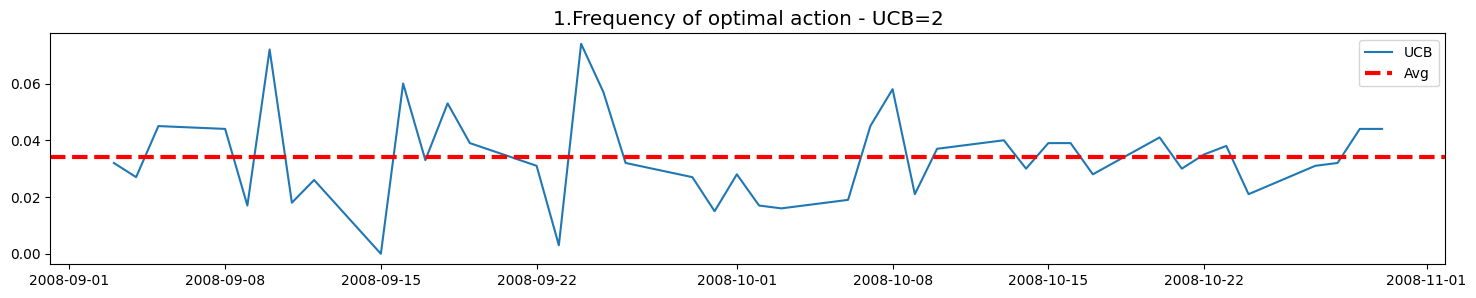

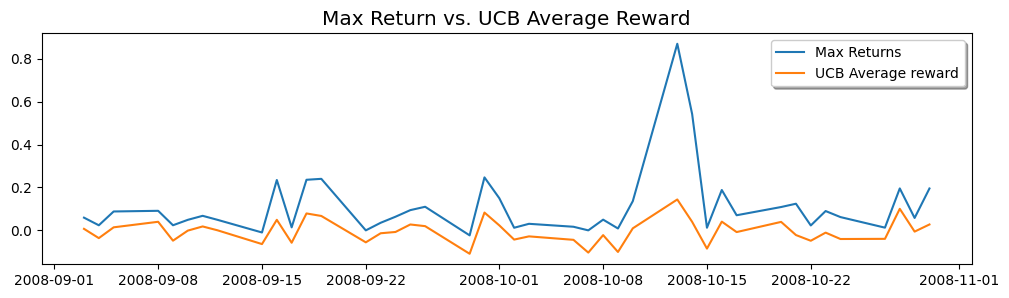

In [ ]:
YData = all_prices.to_numpy()
plt.plot(YData_dates[HOLD  : YData.shape[0]], optimal_avg_ucb, label="UCB")  # noQA E203
plt.axhline(y=np.nanmean(optimal_avg_ucb), color='red', linestyle='--', linewidth=3, label='Avg')
plt.title("1.Frequency of optimal action - UCB=2", fontsize="x-large")

fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.legend()
plt.show()

plt.plot(YData_dates[HOLD:YData.shape[0]],np.max((YData[HOLD:YData.shape[0],:]-YData[0:TMAX,:])/YData[0:TMAX,:],axis=1),label='Max Returns')
plt.plot(YData_dates[HOLD:YData.shape[0]],reward_avg_ucb,label='UCB Average reward')
plt.title("Max Return vs. UCB Average Reward", fontsize="x-large")
legend=plt.legend(loc='upper right', shadow=True)
fig=plt.gcf()
fig.set_size_inches(12,3)
plt.show()

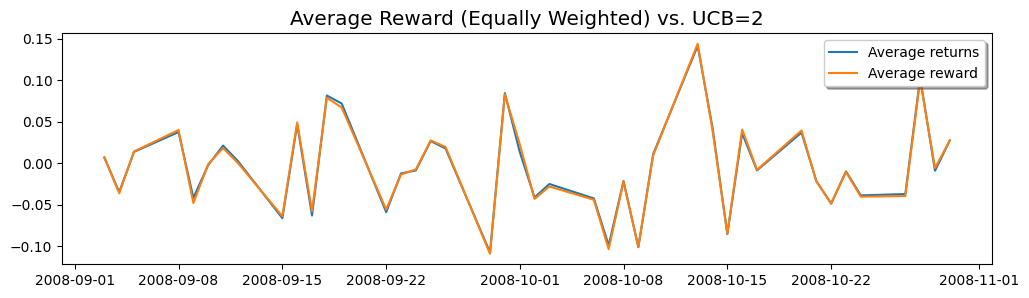

0.03423809523809526
-0.6122217603740219 0.8607592089354736
-0.6224454964985524 0.864021141534326


In [ ]:
plt.plot(YData_dates[HOLD:YData.shape[0]],np.mean((YData[HOLD:YData.shape[0],:]-YData[0:TMAX,:])/YData[0:TMAX,:],axis=1),label='Average returns')
plt.plot(YData_dates[HOLD:YData.shape[0]],reward_avg_ucb,label='Average reward')
plt.title("Average Reward (Equally Weighted) vs. UCB=2", fontsize="x-large")
legend=plt.legend(loc='upper right', shadow=True)
fig=plt.gcf()
fig.set_size_inches(12,3)
plt.show()

#Average frequency of optimal action
print(np.mean(optimal_avg_ucb))
# Average annualized return from holding the equally weighted portfolio
print((1+np.mean((YData[HOLD:YData.shape[0],:]-YData[0:TMAX,:])/YData[0:TMAX,:]))**(250/HOLD)-1, np.sqrt(250/HOLD)*np.std(np.mean((YData[HOLD:YData.shape[0],:]-YData[0:TMAX,:])/YData[0:TMAX,:],axis=1)))
# Average annualized return from holding the Bandit portfolio
print((1+np.mean(reward_avg_ucb))**(250/HOLD)-1, np.sqrt(250/HOLD)*np.std(reward_avg_ucb))

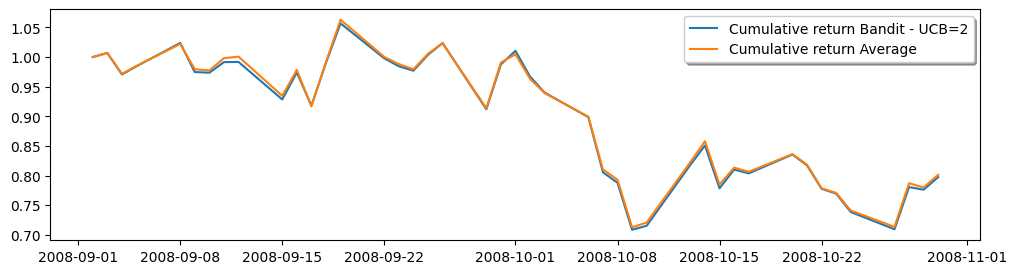

In [ ]:
return_cumulative = np.zeros((TMAX+1,2))
return_cumulative[0,0]=1
return_cumulative[0,1]=1
for tt in range(1,TMAX+1):
  return_cumulative[tt,0]=return_cumulative[tt-1,0]*(1+reward_avg_ucb[tt-1])
  rmean=np.mean((YData[tt+HOLD-1,:]-YData[tt-1,:])/YData[tt-1,:])
  return_cumulative[tt,1]=return_cumulative[tt-1,1]*(1+rmean)

plt.plot(YData_dates[HOLD-1:YData.shape[0]],return_cumulative[:,0],label='Cumulative return Bandit - UCB={}'.format(UCB_EXPORATION_PARAM))
plt.plot(YData_dates[HOLD-1:YData.shape[0]],return_cumulative[:,1],label='Cumulative return Average')
legend=plt.legend(loc='upper right', shadow=True)
fig=plt.gcf()
fig.set_size_inches(12,3)
plt.show()

### STEP 8 - EPS-Greedy Algo

In [ ]:
def EpsilonGreedyMultiBandit (all_prices, eps, N, h, a = None):
  #EPSILON = 0.1
  #ALPHA = 0.975 # We set alpha as simply 1 / number of time action has chosen

  #NEPISODES = 1000
  #HOLD = 1
  YData = all_prices.to_numpy()

  NK = all_prices.shape[1]
  TMAX = all_prices.shape[0] - HOLD

  seed(1234)

  reward_avg_eps = np.zeros((TMAX))
  optimal_avg_eps = np.zeros((TMAX))
  reward_queue_eps = np.zeros((HOLD, 2))

  for run in range(NEPISODES):  # noQA E203
    # Initialize q function and actions record
    qvalue = np.zeros((NK))
    nactions = np.zeros((NK))
    for tt in range(TMAX):  # noQA E203
        #select optimal action
        aa_opt = optimal_action(qvalue, EPSILON)
        nactions[aa_opt] += 1

        # Compute reward as return over holding period
        reward_queue_eps[HOLD - 1, 0] = (
            YData[tt + HOLD, aa_opt] - YData[tt, aa_opt]
        ) / YData[tt, aa_opt]
        reward_queue_eps[HOLD - 1, 1] = aa_opt

        # Update Q function using action chosen HOLD days before
        if (a == None):
          alpha = 1 / nactions[aa_opt]
        else:
          alpha = a
        qvalue = reward_update(
            int(reward_queue_eps[0, 1]), reward_queue_eps[0, 0], qvalue, alpha
        )

        reward_queue_eps[0 : HOLD - 1, :] = reward_queue_eps[1:HOLD, :]  # noQA E203
        reward_avg_eps[tt] += reward_queue_eps[HOLD - 1, 0] / NEPISODES

        #Increment Optimal-count if chosen action has the max reward
        optimal_avg_eps[tt] += (
            aa_opt == np.argmax((YData[tt + HOLD, :] - YData[tt, :]) / YData[tt, :])
        ) / NEPISODES  # noQA E203
  return optimal_avg_eps, reward_avg_eps

In [ ]:
EPSILON = 0 # epsilon = 0 for UCB
# ALPHA = 0.975 # We set alpha as simply 1 / number of time action has chosen
NEPISODES = 1000
HOLD = 1
TMAX = all_prices.shape[0] - HOLD



EPSILON = 0.1 # epsilon = .1 for E-Greedy
optimal_avg_eps, reward_avg_eps = EpsilonGreedyMultiBandit (all_prices, EPSILON, NEPISODES, HOLD)

**Here we plot four charts for E-Greedy Algo**

1/ Frequency of optimal action

2/ Max Return vs. UCB Average Reward

3/ Average Reward (Equally Weighted) vs. E-Greedy


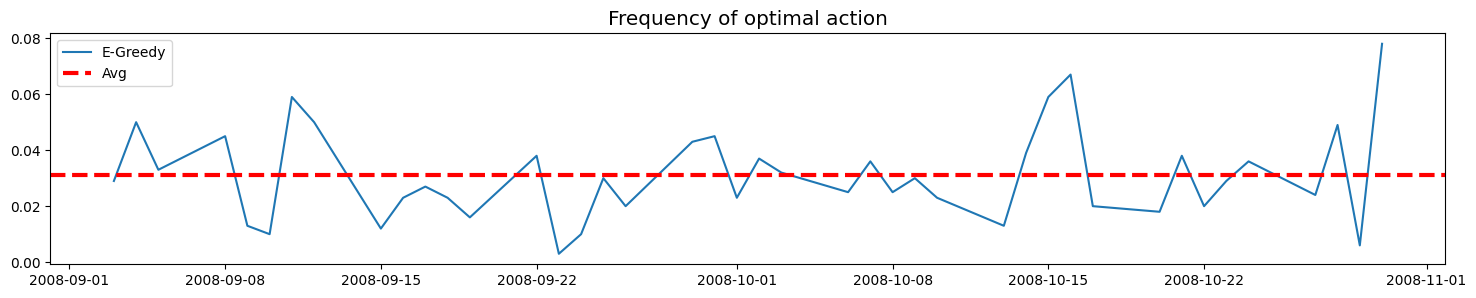

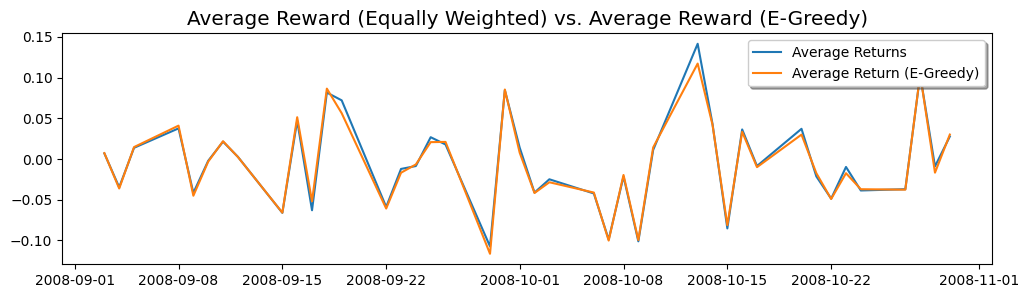

In [ ]:
HOLD = 1
YData = all_prices.to_numpy()
plt.plot(YData_dates[HOLD  : YData.shape[0]], optimal_avg_eps, label="E-Greedy")  # noQA E203
plt.axhline(y=np.nanmean(optimal_avg_eps), color='red', linestyle='--', linewidth=3, label='Avg')

plt.title("Frequency of optimal action", fontsize="x-large")

fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.legend()
plt.show()

plt.plot(YData_dates[HOLD:YData.shape[0]],np.mean((YData[HOLD:YData.shape[0],:]-YData[0:TMAX,:])/YData[0:TMAX,:],axis=1),label='Average Returns')
plt.plot(YData_dates[HOLD:YData.shape[0]],reward_avg_eps,label='Average Return (E-Greedy)')

legend=plt.legend(loc='upper right', shadow=True)
plt.title("Average Reward (Equally Weighted) vs. Average Reward (E-Greedy)", fontsize="x-large")

fig=plt.gcf()
fig.set_size_inches(12,3)
plt.show()


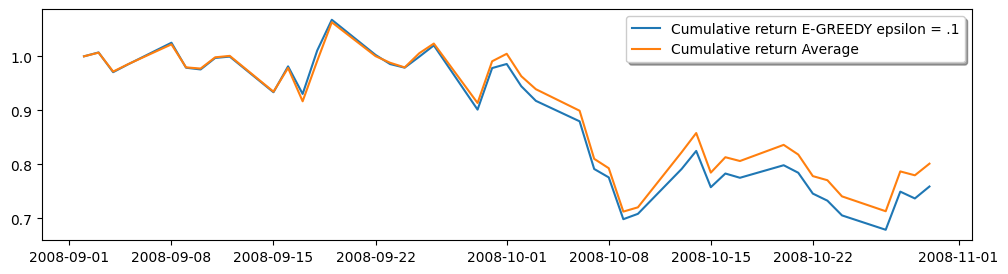

In [ ]:
HOLD = 1
return_cumulative = np.zeros((TMAX+1,2))
return_cumulative[0,0]=1
return_cumulative[0,1]=1
for tt in range(1,TMAX+1):
  return_cumulative[tt,0]=return_cumulative[tt-1,0]*(1+reward_avg_eps[tt-1])
  rmean=np.mean((YData[tt+HOLD-1,:]-YData[tt-1,:])/YData[tt-1,:])
  return_cumulative[tt,1]=return_cumulative[tt-1,1]*(1+rmean)

plt.plot(YData_dates[HOLD-1:YData.shape[0]],return_cumulative[:,0],label='Cumulative return E-GREEDY epsilon = .1')
plt.plot(YData_dates[HOLD-1:YData.shape[0]],return_cumulative[:,1],label='Cumulative return Average')
legend=plt.legend(loc='upper right', shadow=True)
fig=plt.gcf()
fig.set_size_inches(12,3)
plt.show()

## STEP 9

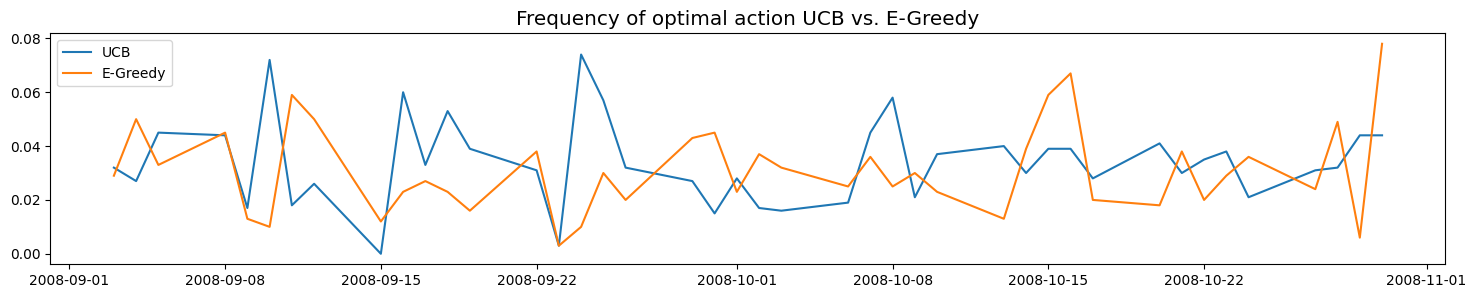

In [ ]:
plt.plot(YData_dates[HOLD : YData.shape[0]], optimal_avg_ucb, label="UCB")  # noQA E203
plt.plot(YData_dates[HOLD : YData.shape[0]], optimal_avg_eps , label="E-Greedy")  # noQA E203
plt.title("Frequency of optimal action UCB vs. E-Greedy", fontsize="x-large")

fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.legend()
plt.show()


In [ ]:
from tabulate import tabulate
table = [["Average frequency of optimal action under EPS",np.mean(optimal_avg_eps)],["Average frequency of optimal action under UCB", np.mean(optimal_avg_ucb)]]
print(tabulate(table))

---------------------------------------------  ---------
Average frequency of optimal action under EPS  0.0310952
Average frequency of optimal action under UCB  0.0342381
---------------------------------------------  ---------


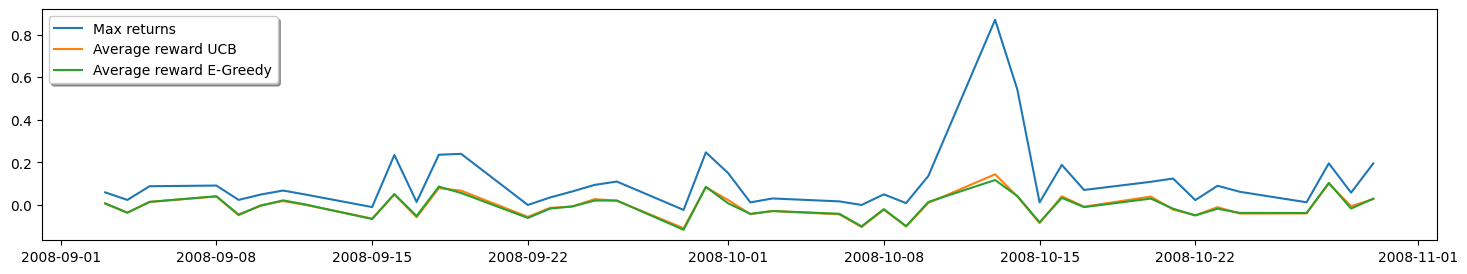

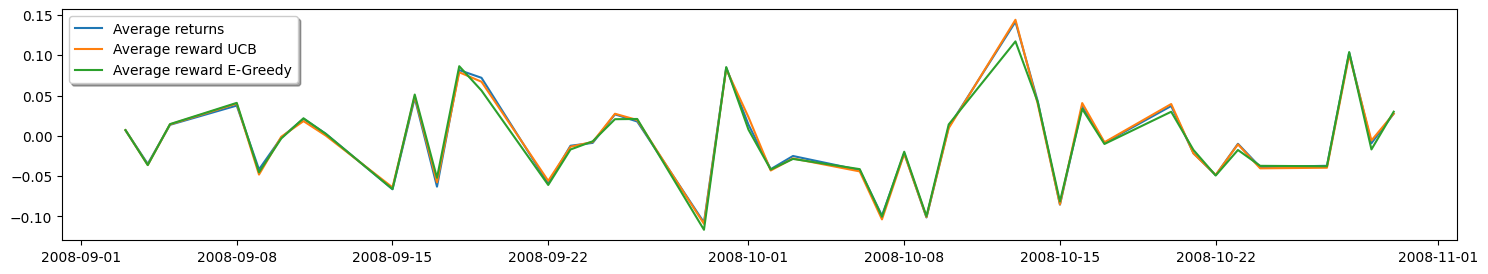

-0.6122217603740219 0.8607592089354736
-0.7239422233537153 0.8370154513677247
-0.6224454964985524 0.864021141534326


In [ ]:
plt.plot(
    YData_dates[HOLD : YData.shape[0]],
    np.max(
        (YData[HOLD : YData.shape[0], :] - YData[0:TMAX, :]) / YData[0:TMAX, :], axis=1
    ),
    label="Max returns",
)  # noQA E203

plt.plot(
    YData_dates[HOLD : YData.shape[0]], reward_avg_ucb, label="Average reward UCB"
)  # noQA E203

plt.plot(
    YData_dates[HOLD : YData.shape[0]], reward_avg_eps, label="Average reward E-Greedy"
)  # noQA E203

legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData_dates[HOLD : YData.shape[0]],
    np.mean(
        (YData[HOLD : YData.shape[0], :] - YData[0:TMAX, :]) / YData[0:TMAX, :], axis=1
    ),
    label="Average returns",
)  # noQA E203

plt.plot(
    YData_dates[HOLD : YData.shape[0]], reward_avg_ucb, label="Average reward UCB"
)  # noQA E203

plt.plot(
    YData_dates[HOLD : YData.shape[0]], reward_avg_eps, label="Average reward E-Greedy"
)  # noQA E203

legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

# Average annualized return from holding the equally weighted portfolio
print((1+np.mean((YData[HOLD:YData.shape[0],:]-YData[0:TMAX,:])/YData[0:TMAX,:]))**(250/HOLD)-1, np.sqrt(250/HOLD)*np.std(np.mean((YData[HOLD:YData.shape[0],:]-YData[0:TMAX,:])/YData[0:TMAX,:],axis=1)))
# Average annualized return from holding the Bandit- EPSILON portfolio
print((1+np.mean(reward_avg_eps))**(250/HOLD)-1, np.sqrt(250/HOLD)*np.std(reward_avg_eps))
# Average annualized return from holding the Bandit- UCB portfolio
print((1+np.mean(reward_avg_ucb))**(250/HOLD)-1, np.sqrt(250/HOLD)*np.std(reward_avg_ucb))

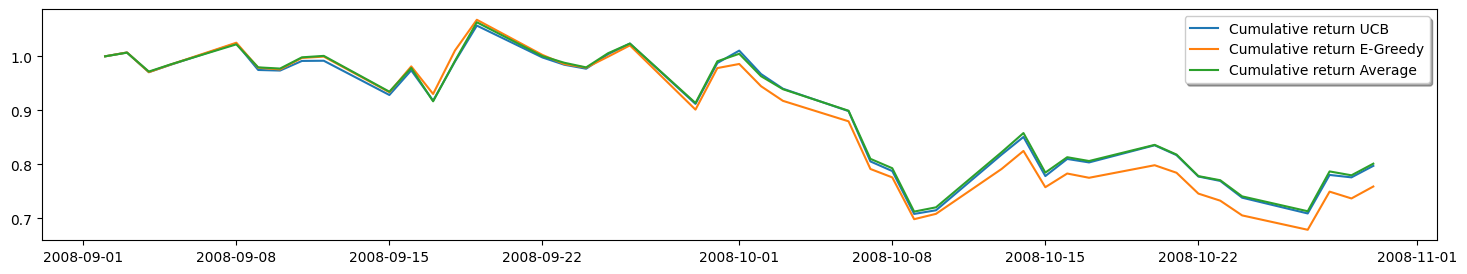

In [ ]:
return_cumulative = np.zeros((TMAX + 1, 3))
return_cumulative[0, 0] = 1
return_cumulative[0, 1] = 1
return_cumulative[0, 2] = 1
for tt in range(1, TMAX + 1):  # noQA E203
    return_cumulative[tt, 0] = return_cumulative[tt - 1, 0] * (1 + reward_avg_ucb[tt - 1])
    return_cumulative[tt, 2] = return_cumulative[tt - 1, 2] * (1 + reward_avg_eps[tt - 1])
    rmean = np.mean(
        (YData[tt + HOLD - 1, :] - YData[tt - 1, :]) / YData[tt - 1, :]
    )  # noQA E203
    return_cumulative[tt, 1] = return_cumulative[tt - 1, 1] * (1 + rmean)  # noQA E203


plt.plot(
    YData_dates[HOLD - 1 : YData.shape[0]],
    return_cumulative[:, 0],
    label="Cumulative return UCB",
)  # noQA E203
plt.plot(
    YData_dates[HOLD - 1 : YData.shape[0]],
    return_cumulative[:, 2],
    label="Cumulative return E-Greedy",
)  # noQA E203
plt.plot(
    YData_dates[HOLD - 1 : YData.shape[0]],
    return_cumulative[:, 1],
    label="Cumulative return Average",
)  # noQA E203
legend = plt.legend(loc="upper right", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

## Step 10 - More recent data from 2020-04 to 2022-04

In [ ]:
all_data_new = yf.download(all_tickers,  '2020-04-01',  '2022-04-30')

[*********************100%%**********************]  30 of 30 completed


In [ ]:
all_prices_new = all_data_new['Adj Close']
YData_new = all_prices_new.to_numpy()
YData_dates_new = pd.to_datetime(all_prices_new.reset_index()['Date'], format="%Y-%m-%d")

all_stock_returns = all_data_new.pct_change()

In [ ]:
EPSILON = 0.5
NEPISODES = 1000
HOLD = 1
TMAX = YData_new.shape[0] - HOLD

optimal_avg_ucb5, reward_avg_ucb5  = UCBMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD,1)

EPSILON = 0.5 # epsilon = .1 for E-Greedy
optimal_avg_eps5, reward_avg_eps5 = EpsilonGreedyMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD)

###For Holding period =1

EPSILON = 0.75
NEPISODES = 1000

TMAX = YData_new.shape[0] - HOLD

optimal_avg_ucb1, reward_avg_ucb1  = UCBMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD,1)

EPSILON = 0.75 # epsilon = .1 for E-Greedy
optimal_avg_eps1, reward_avg_eps1 = EpsilonGreedyMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD)

EPSILON = 0.75
NEPISODES = 1000

TMAX = YData_new.shape[0] - HOLD

optimal_avg_ucb25, reward_avg_ucb25  = UCBMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD,1)

EPSILON = 0.75 # epsilon = .1 for E-Greedy
optimal_avg_eps25, reward_avg_eps25 = EpsilonGreedyMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD)

EPSILON = 0.95
NEPISODES = 1000
TMAX = YData_new.shape[0] - HOLD

optimal_avg_ucb100, reward_avg_ucb100  = UCBMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD,1)

EPSILON = 0.95 # epsilon = .1 for E-Greedy
optimal_avg_eps100, reward_avg_eps100 = EpsilonGreedyMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD)

In [ ]:
print ("Frequency of optimal action ")
print ()
table = [["Alpha=.5",np.mean(optimal_avg_eps5),np.mean(optimal_avg_ucb5)],["Alpha=.75",np.mean(optimal_avg_eps25),np.mean(optimal_avg_ucb25)],["Alpha=.95",np.mean(optimal_avg_eps100),np.mean(optimal_avg_ucb100)]]

print(tabulate(table, headers=["E-Greedy", "UCB"], tablefmt="github"))

Frequency of optimal action 

|           |   E-Greedy |       UCB |
|-----------|------------|-----------|
| Alpha=.5  |  0.0372023 | 0.0336355 |
| Alpha=.75 |  0.0357271 | 0.0334351 |
| Alpha=.95 |  0.0341221 | 0.0333435 |


In [ ]:
EPSILON = 0.1
NEPISODES = 1000
HOLD = 5
TMAX = YData_new.shape[0] - HOLD

optimal_avg_ucb5, reward_avg_ucb5  = UCBMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD,1)

EPSILON = 0.1 # epsilon = .1 for E-Greedy
optimal_avg_eps5, reward_avg_eps5 = EpsilonGreedyMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD)

###For Holding period =1

EPSILON = 0.1
NEPISODES = 1000
HOLD = 1
TMAX = YData_new.shape[0] - HOLD

optimal_avg_ucb1, reward_avg_ucb1  = UCBMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD,1)

EPSILON = 0.1 # epsilon = .1 for E-Greedy
optimal_avg_eps1, reward_avg_eps1 = EpsilonGreedyMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD)

EPSILON = 0.1
NEPISODES = 1000
HOLD = 25
TMAX = YData_new.shape[0] - HOLD

optimal_avg_ucb25, reward_avg_ucb25  = UCBMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD,1)

EPSILON = 0.1 # epsilon = .1 for E-Greedy
optimal_avg_eps25, reward_avg_eps25 = EpsilonGreedyMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD)

EPSILON = 0.1
NEPISODES = 1000
HOLD = 100
TMAX = YData_new.shape[0] - HOLD

optimal_avg_ucb100, reward_avg_ucb100  = UCBMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD,1)

EPSILON = 0.1 # epsilon = .1 for E-Greedy
optimal_avg_eps100, reward_avg_eps100 = EpsilonGreedyMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD)

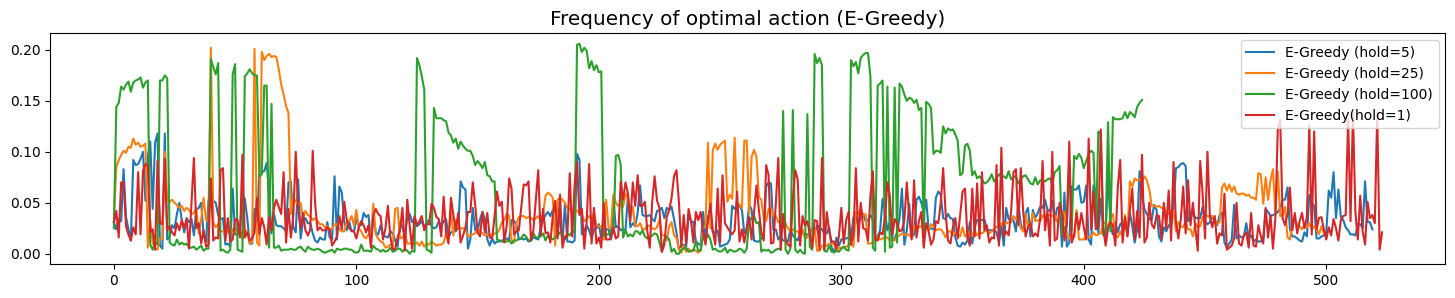

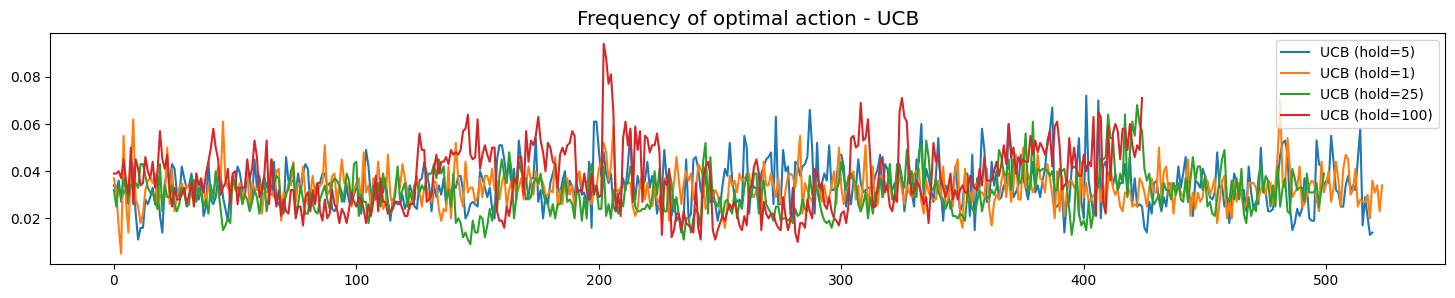

In [ ]:
plt.plot( optimal_avg_eps5 , label="E-Greedy (hold=5)")  # noQA E203
plt.plot( optimal_avg_eps25 , label="E-Greedy (hold=25)")  # noQA E203
plt.plot( optimal_avg_eps100 , label="E-Greedy (hold=100)")  # noQA E203
plt.plot( optimal_avg_eps1 , label="E-Greedy(hold=1) ")  # noQA E203
plt.title("Frequency of optimal action (E-Greedy)", fontsize="x-large")

fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.legend()
plt.show()


plt.plot(optimal_avg_ucb5, label="UCB (hold=5)")  # noQA E203
plt.plot(optimal_avg_ucb1, label="UCB (hold=1)")  # noQA E203
plt.plot(optimal_avg_ucb25, label="UCB (hold=25)")  # noQA E203
plt.plot(optimal_avg_ucb100, label="UCB (hold=100)")  # noQA E203
plt.title("Frequency of optimal action - UCB", fontsize="x-large")

fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.legend()
plt.show()


In [ ]:
#Average frequency of optimal action EPSILON

from tabulate import tabulate
print ("Frequency of optimal action ")
print ()
table = [["Hold=1",np.mean(optimal_avg_eps1),np.mean(optimal_avg_ucb1)],["Hold=5",np.mean(optimal_avg_eps5),np.mean(optimal_avg_ucb5)],["Hold=25",np.mean(optimal_avg_eps25),np.mean(optimal_avg_ucb25)],["Hold=100",np.mean(optimal_avg_eps100),np.mean(optimal_avg_ucb100)]]

print(tabulate(table, headers=["E-Greedy", "UCB"], tablefmt="github"))

Frequency of optimal action 

|          |   E-Greedy |       UCB |
|----------|------------|-----------|
| Hold=1   |  0.0354809 | 0.0328473 |
| Hold=5   |  0.0323096 | 0.0338462 |
| Hold=25  |  0.037968  | 0.03096   |
| Hold=100 |  0.0632353 | 0.0368612 |


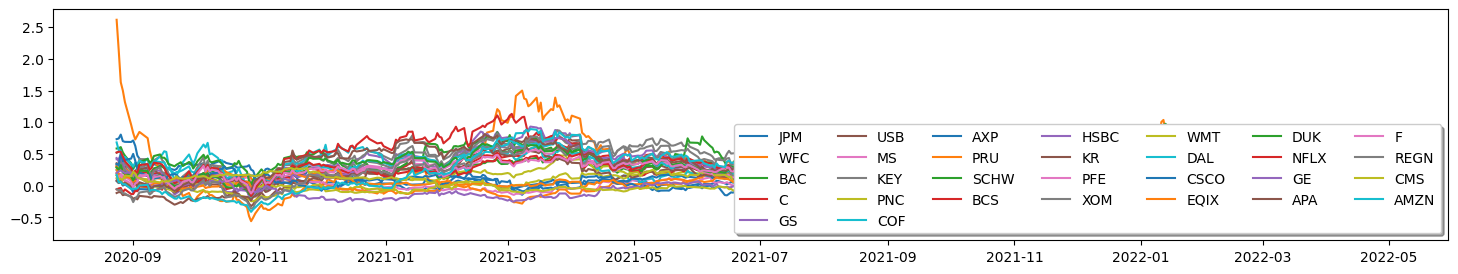

100


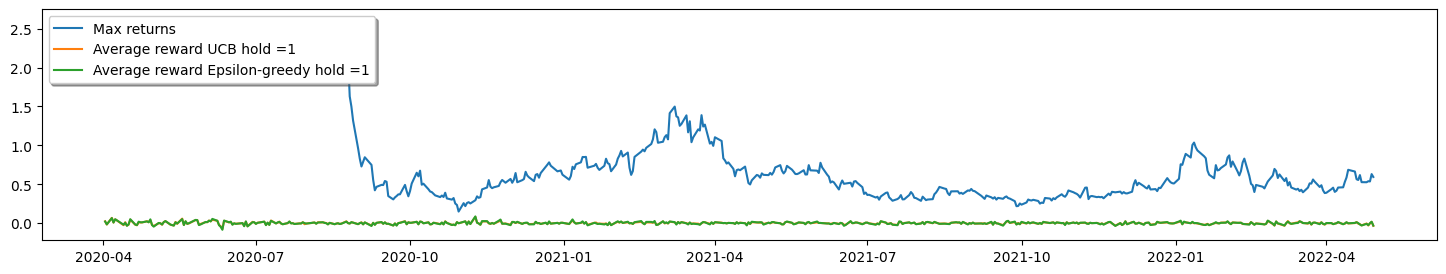

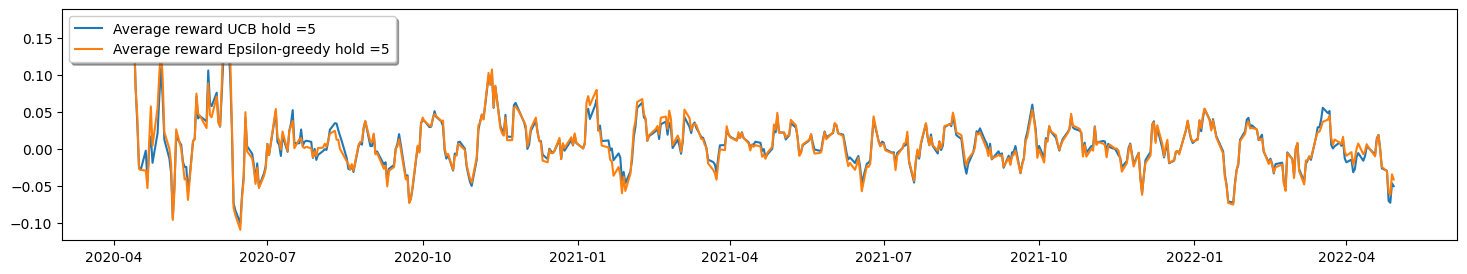

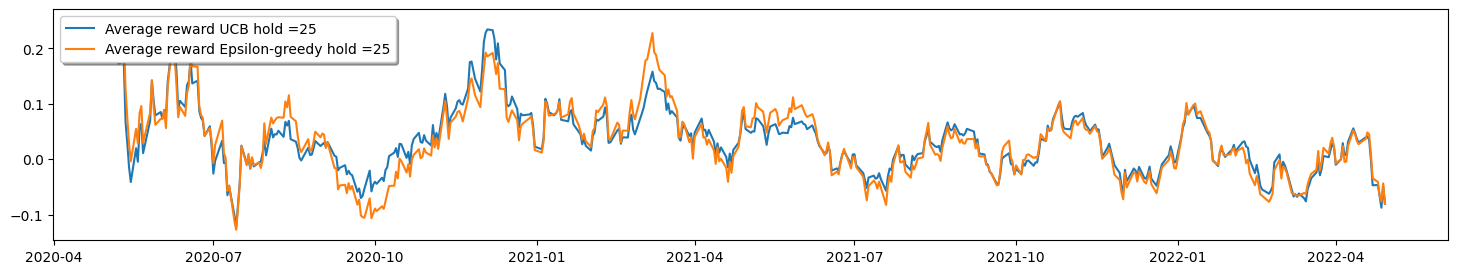

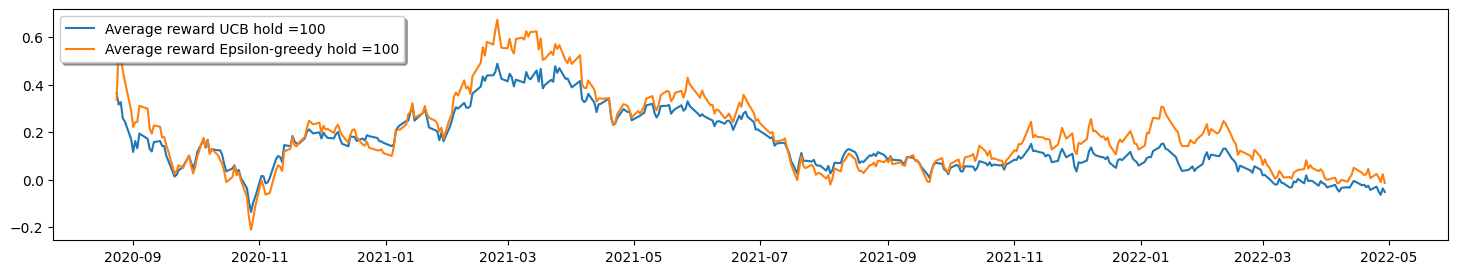

In [ ]:
plt.plot(
    YData_dates_new[100 : YData_new.shape[0]],
    (YData_new[100 : YData_new.shape[0], :] - YData_new[0:TMAX, :]) / YData_new[0:TMAX, :],
)  # noQA E203
plt.legend(all_tickers,  loc="lower right", ncol=7, shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

print(HOLD)
plt.plot(
    YData_dates_new[100 : YData_new.shape[0]],
    np.max(
        (YData_new[100 : YData_new.shape[0], :] - YData_new[0:TMAX, :]) / YData_new[0:TMAX, :], axis=1
    ),
    label="Max returns",
)  # noQA E203

plt.plot(
    YData_dates_new[1 : YData_new.shape[0]], reward_avg_ucb1, label="Average reward UCB hold =1"
)  # noQA E203
plt.plot(
    YData_dates_new[1 : YData_new.shape[0]], reward_avg_eps1, label="Average reward Epsilon-greedy hold =1"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()


plt.plot(
    YData_dates_new[5 : YData_new.shape[0]], reward_avg_ucb5, label="Average reward UCB hold =5"
)  # noQA E203
plt.plot(
    YData_dates_new[5 : YData_new.shape[0]], reward_avg_eps5, label="Average reward Epsilon-greedy hold =5"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData_dates_new[25 : YData_new.shape[0]], reward_avg_ucb25, label="Average reward UCB hold =25"
)  # noQA E203
plt.plot(
    YData_dates_new[25 : YData_new.shape[0]], reward_avg_eps25, label="Average reward Epsilon-greedy hold =25"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

plt.plot(
    YData_dates_new[100 : YData_new.shape[0]], reward_avg_ucb100, label="Average reward UCB hold =100"
)  # noQA E203
plt.plot(
    YData_dates_new[100 : YData_new.shape[0]], reward_avg_eps100, label="Average reward Epsilon-greedy hold =100"
)  # noQA E203
legend = plt.legend(loc="upper left", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

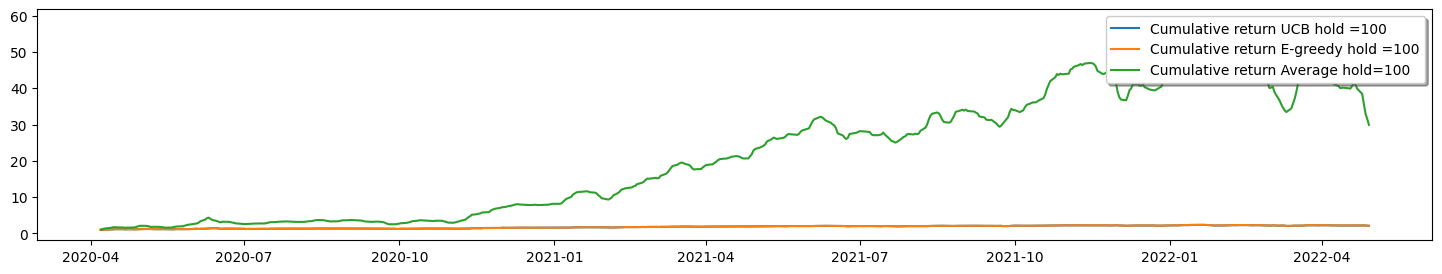

In [ ]:
HOLD=5
TMAX = YData_new.shape[0] - HOLD
return_cumulative = np.zeros((TMAX + 1, 3))
return_cumulative[0, 0] = 1
return_cumulative[0, 1] = 1
return_cumulative[0, 2] = 1
for tt in range(1, TMAX + 1):  # noQA E203
    return_cumulative[tt, 0] = return_cumulative[tt - 1, 0] * (1 + reward_avg_ucb100[tt - 1])
    return_cumulative[tt, 2] = return_cumulative[tt - 1, 2] * (1 + reward_avg_eps100[tt - 1])
    rmean = np.mean(
        (YData_new[tt + HOLD - 1, :] - YData_new[tt - 1, :]) / YData_new[tt - 1, :]
    )  # noQA E203
    return_cumulative[tt, 1] = return_cumulative[tt - 1, 1] * (1 + rmean)  # noQA E203


plt.plot(
    YData_dates_new[HOLD - 1 : YData_new.shape[0]],
    return_cumulative[:, 0],
    label="Cumulative return UCB hold =100",
)  # noQA E203
plt.plot(
    YData_dates_new[HOLD - 1 : YData_new.shape[0]],
    return_cumulative[:, 2],
    label="Cumulative return E-greedy hold =100",
)  # noQA E203
plt.plot(
    YData_dates_new[HOLD - 1 : YData_new.shape[0]],
    return_cumulative[:, 1],
    label="Cumulative return Average hold=100",
)  # noQA E203
legend = plt.legend(loc="upper right", shadow=True)
fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.show()

###Step 11

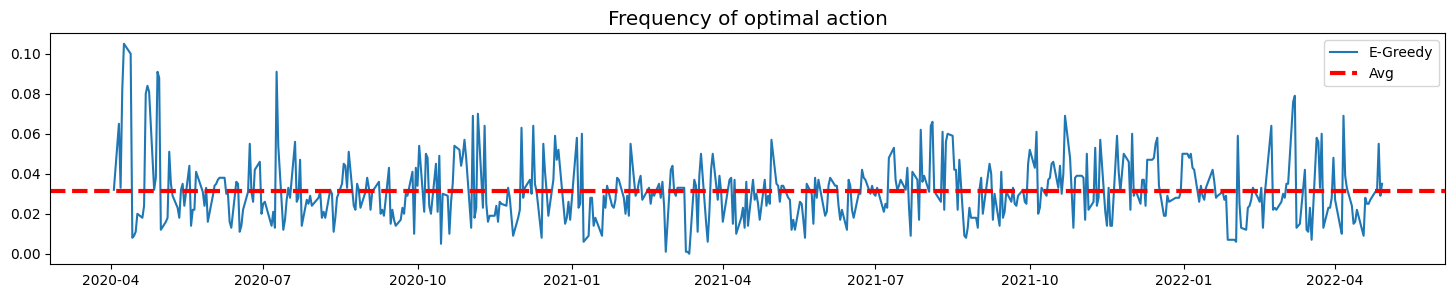

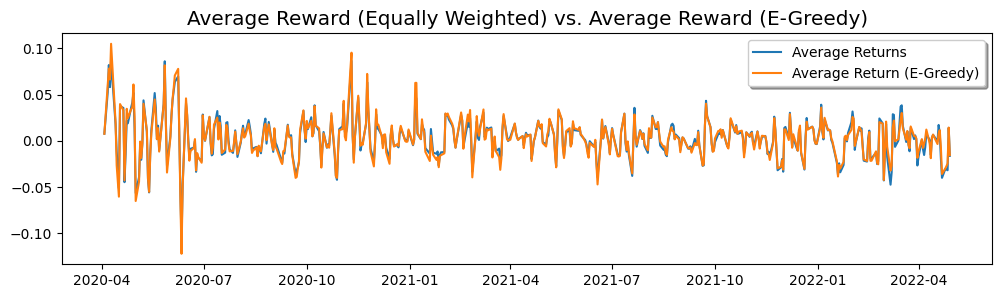

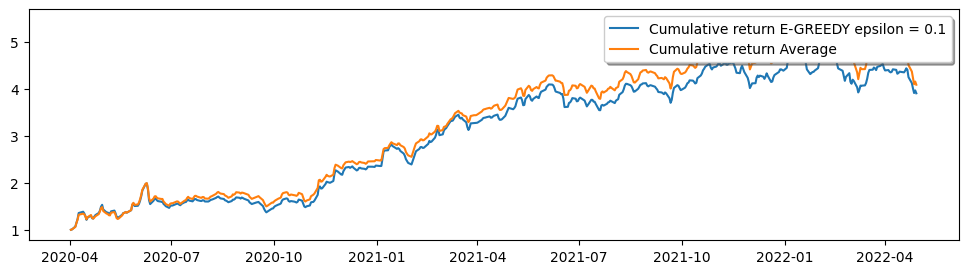

In [ ]:
# ALPHA = 0.975 # We set alpha as simply 1 / number of time action has chosen
NEPISODES = 1000
HOLD = 2
TMAX = YData_new.shape[0] - HOLD


EPSILON = 0.1 # epsilon = .1 for E-Greedy
optimal_avg_eps, reward_avg_eps = EpsilonGreedyMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD)

YData = all_prices_new.to_numpy()
plt.plot(YData_dates_new[HOLD  : YData.shape[0]], optimal_avg_eps, label="E-Greedy")  # noQA E203
plt.axhline(y=np.nanmean(optimal_avg_eps), color='red', linestyle='--', linewidth=3, label='Avg')

plt.title("Frequency of optimal action", fontsize="x-large")

fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.legend()
plt.show()

plt.plot(YData_dates_new[HOLD:YData.shape[0]],np.mean((YData[HOLD:YData.shape[0],:]-YData[0:TMAX,:])/YData[0:TMAX,:],axis=1),label='Average Returns')
plt.plot(YData_dates_new[HOLD:YData.shape[0]],reward_avg_eps,label='Average Return (E-Greedy)')

legend=plt.legend(loc='upper right', shadow=True)
plt.title("Average Reward (Equally Weighted) vs. Average Reward (E-Greedy)", fontsize="x-large")

fig=plt.gcf()
fig.set_size_inches(12,3)
plt.show()


return_cumulative = np.zeros((TMAX+1,2))
return_cumulative[0,0]=1
return_cumulative[0,1]=1
for tt in range(1,TMAX+1):
  return_cumulative[tt,0]=return_cumulative[tt-1,0]*(1+reward_avg_eps[tt-1])
  rmean=np.mean((YData[tt+HOLD-1,:]-YData[tt-1,:])/YData[tt-1,:])
  return_cumulative[tt,1]=return_cumulative[tt-1,1]*(1+rmean)

plt.plot(YData_dates_new[HOLD-1:YData.shape[0]],return_cumulative[:,0],label='Cumulative return E-GREEDY epsilon = {}'.format(EPSILON))
plt.plot(YData_dates_new[HOLD-1:YData.shape[0]],return_cumulative[:,1],label='Cumulative return Average')
legend=plt.legend(loc='upper right', shadow=True)
fig=plt.gcf()
fig.set_size_inches(12,3)
plt.show()


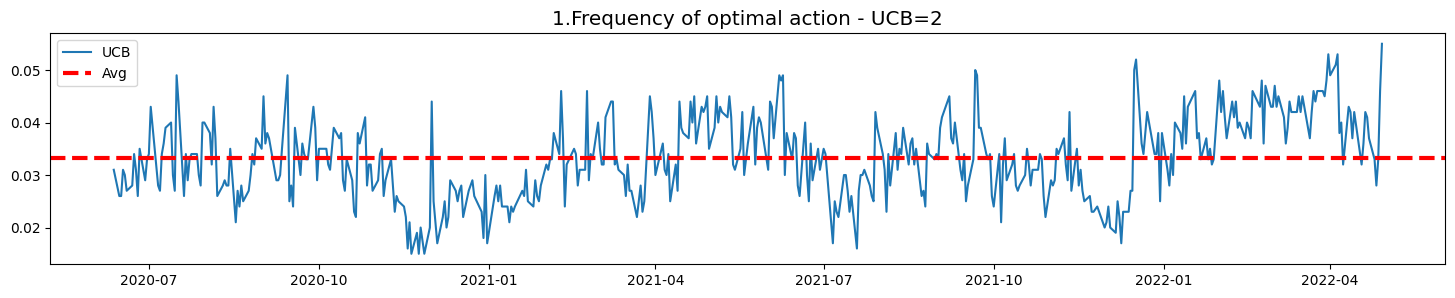

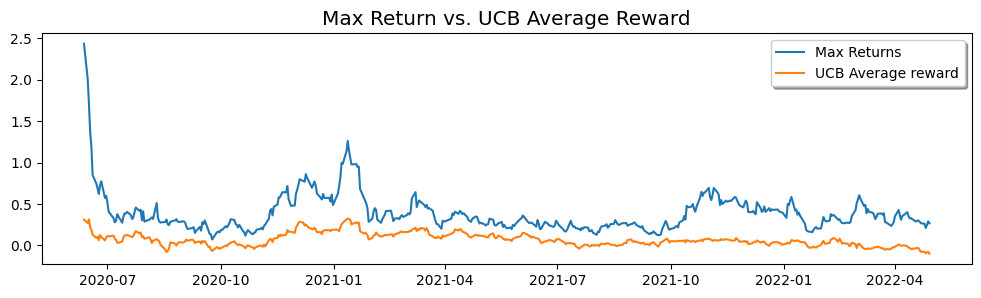

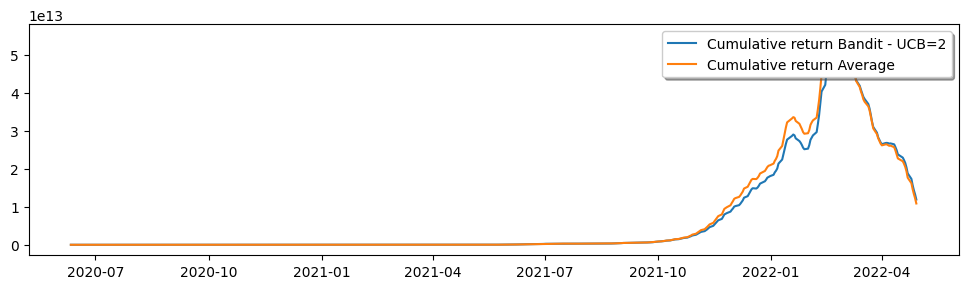

In [ ]:
EPSILON = 0 # epsilon = 0 for UCB
# ALPHA = 0.975 # We set alpha as simply 1 / number of time action has chosen
HOLD = 50
TMAX = YData_new.shape[0] - HOLD
UCB_EXPORATION_PARAM = 2

optimal_avg_ucb, reward_avg_ucb  = UCBMultiBandit (all_prices_new, EPSILON, NEPISODES, HOLD)

YData = all_prices_new.to_numpy()
plt.plot(YData_dates_new[HOLD  : YData.shape[0]], optimal_avg_ucb, label="UCB")  # noQA E203
plt.axhline(y=np.nanmean(optimal_avg_ucb), color='red', linestyle='--', linewidth=3, label='Avg')
plt.title("1.Frequency of optimal action - UCB={}".format(UCB_EXPORATION_PARAM), fontsize="x-large")

fig = plt.gcf()
fig.set_size_inches(18, 3)
plt.legend()
plt.show()

plt.plot(YData_dates_new[HOLD:YData.shape[0]],np.max((YData[HOLD:YData.shape[0],:]-YData[0:TMAX,:])/YData[0:TMAX,:],axis=1),label='Max Returns')
plt.plot(YData_dates_new[HOLD:YData.shape[0]],reward_avg_ucb,label='UCB Average reward')
plt.title("Max Return vs. UCB Average Reward", fontsize="x-large")
legend=plt.legend(loc='upper right', shadow=True)
fig=plt.gcf()
fig.set_size_inches(12,3)
plt.show()

return_cumulative = np.zeros((TMAX+1,2))
return_cumulative[0,0]=1
return_cumulative[0,1]=1
for tt in range(1,TMAX+1):
  return_cumulative[tt,0]=return_cumulative[tt-1,0]*(1+reward_avg_ucb[tt-1])
  rmean=np.mean((YData[tt+HOLD-1,:]-YData[tt-1,:])/YData[tt-1,:])
  return_cumulative[tt,1]=return_cumulative[tt-1,1]*(1+rmean)

plt.plot(YData_dates_new[HOLD-1:YData.shape[0]],return_cumulative[:,0],label='Cumulative return Bandit - UCB={}'.format(UCB_EXPORATION_PARAM))
plt.plot(YData_dates_new[HOLD-1:YData.shape[0]],return_cumulative[:,1],label='Cumulative return Average')
legend=plt.legend(loc='upper right', shadow=True)
fig=plt.gcf()
fig.set_size_inches(12,3)
plt.show()